# Contextual Bandits: a rating environment

This notebook explore agents performance on a rating environment, also known as explicit feedback.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
import random
from scipy.stats import norm

In [2]:
def random_argmax(rng, list_):
    """ similar to np.argmax but return a random element among max
        when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [3]:
np.set_printoptions(precision=2)

## Environment
The Multi-Armed Bandit setting is as follow: 

At each step you have to chose one arm to pull and recieve a reward accordingly.

Here we consider Bernoulli rewards.

In [4]:
class ExplicitFeedback:
    """ A rating environment with explicit feedback.
        User and items are represented by points in R^k
        User interest for a given item is modeled by a parametric function
        R_{u,i} = f(u,i) = f(W_u, W_i)
        Example of function include dot product (cosine similarity)
        R_{u,i} = \sum_k w_{u,k} . w_{i,k}
        action: Recommend one item for a given user among those he has never bought before
    """

    def __init__(self, nb_users=30, nb_items=10, 
                 internal_embedding_size=3,
                 displayed_users_embedding_size=2,
                 displayed_items_embedding_size=2,
                 noise_size=3,
                 seed=None):
        self.nb_users = nb_users
        self.nb_items = nb_items
        self.internal_embedding_size = internal_embedding_size
        self.displayed_users_embedding_size = displayed_users_embedding_size
        self.displayed_items_embedding_size = displayed_items_embedding_size
        self.noise_size = noise_size
        self._rng = np.random.RandomState(seed)
        
        self.action_size = self.nb_items
        self.sampling_limit = nb_users * nb_items
        self.user_mean = np.ones(self.internal_embedding_size)
        self.user_var = np.ones(self.internal_embedding_size)
        self.item_mean = np.ones(self.internal_embedding_size)
        self.item_var = np.ones(self.internal_embedding_size)
        self.users_embedding = None
        self.items_embedding = None
        self.user_item_history = None
        self.z_cut_points = None
        self.done = False

    def step(self, action):
        # check if behind done
        if self.done: #self.user_item_history.sum() >= self.sampling_limit:
            print("You are calling step after it return done=True.\n"
                  "You should reset the environment.")

        assert action < self.action_size
        self.action = action
        
        # compute potential rewards
        potential_rewards = [self._get_user_item_rating(self.current_user, i) 
                             for i in np.argwhere(self.user_item_history[self.current_user, :] == 0).flatten()]
        
        optimal_return = np.max(potential_rewards)

        # map action to item
        self.recommended_item = np.argwhere(self.user_item_history[self.current_user, :] == 0)[action][0]

        # mark item as rated
        self.user_item_history[self.current_user, self.recommended_item] = 1

        # compute reward R_t
        self.current_rating = self._get_user_item_rating(self.current_user, self.recommended_item)
        self.reward = self.current_rating
        
        # check if done
        if self.user_item_history.sum() == self.sampling_limit:
            self.done = True

        # compute next state S_{t+1}
        self._next_state()

        # update action space t+1
        self.action_size = len(self.available_items)

        return self.reward, self.state, self.done, optimal_return

    def reset(self, seed=None):
        self._rng = np.random.RandomState(seed)
        self.action_size = self.nb_items
        
        # create users and items embedding matrix
        self.users_embedding = self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self.nb_users, self.internal_embedding_size))
        self.items_embedding = self._rng.normal(loc=self.item_mean,
                                                scale=self.item_var,
                                                size=(self.nb_items, self.internal_embedding_size))

        # Let X = users_embedding and Y = items_embedding
        # In order to properly map float into integers, we need to know the distribution of
        # Z = \sum_k X_k.Y_k
        # E[Z] = \sum_k E[X_k.Y_k] = \sum_k E[X_k]E[Y_k]
        # Var[Z] = \sum_k Var[X_k.Y_k] = \sum_k Var[X_k]Var[Y_k] + Var[X_k]E[Y_k]^2 + Var[Y_k]E[X_k]^2
        z_mean = self.user_mean.dot(self.item_mean)
        z_var = self.user_var.dot(self.item_var) + self.user_var.dot(np.square(self.item_mean)) + \
                self.item_var.dot(np.square(self.user_mean))
        z = norm(z_mean, np.sqrt(z_var))
        # to get 5 values, we need 4 cut points
        self.z_cut_points = z.ppf([0.2, 0.4, 0.6, 0.8]) # you can control the distribution of ratings here.
        self.user_item_history = np.zeros((self.nb_users, self.nb_items))
        self.done = False

        self._next_state()
        return self.state

    def _get_user_item_rating(self, user, item):
        real_score = self.users_embedding[user].dot(self.items_embedding[item])
        integer_score = np.searchsorted(self.z_cut_points, real_score) + 1
        return integer_score

    def _get_variables(self, user, item):
        user_embedding = self.users_embedding[user]
        item_embedding = self.items_embedding[item]
        if self.displayed_users_embedding_size + self.displayed_items_embedding_size > 0:
            variables = np.array([user_embedding[:self.displayed_users_embedding_size],
                                  item_embedding[:self.displayed_items_embedding_size]])

            if self.noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self.noise_size),
                                         scale=np.ones(self.noise_size),
                                         size=self.noise_size)
                variables = np.append(variables, noise)

            return variables

    def _get_new_user(self):
        for i in range(10):
            user = self._rng.randint(0, self.nb_users)
            # check it remain at least one item
            if np.sum(self.user_item_history[user, :]) < self.nb_items:
                return user
        return self._rng.choice(np.argwhere(self.user_item_history == 0))[0]

    def _next_state(self):
        # Pick a user
        if self.user_item_history.sum() < self.sampling_limit:
            self.current_user = self._get_new_user()
        else:
            self.current_user = None

        # List available items
        self.available_items = np.argwhere(self.user_item_history[self.current_user, :] == 0)

        self.state = list()
        for i in self.available_items:
            item = i[0]
            # Compute variables
            variables = self._get_variables(self.current_user, item)
            self.state.append([self.current_user, item, variables])


In [5]:
env = ExplicitFeedback()

In [6]:
env.reset(seed=2020)

[[11, 0, array([ 0.69,  2.24,  1.32,  2.05, -0.35,  1.84,  2.02])],
 [11, 1, array([0.69, 2.24, 0.57, 1.12, 1.74, 1.14, 2.4 ])],
 [11, 2, array([0.69, 2.24, 0.03, 0.65, 0.34, 2.01, 1.88])],
 [11, 3, array([0.69, 2.24, 0.07, 1.55, 0.01, 0.36, 2.24])],
 [11, 4, array([0.69, 2.24, 0.75, 0.83, 1.44, 0.41, 0.95])],
 [11, 5, array([ 0.69,  2.24,  0.78,  0.72, -1.97,  0.14, -1.01])],
 [11, 6, array([ 0.69,  2.24, -1.49,  0.88,  2.08,  1.32,  0.86])],
 [11, 7, array([0.69, 2.24, 1.44, 0.5 , 0.32, 1.23, 0.48])],
 [11, 8, array([ 0.69,  2.24,  1.58, -0.06,  0.72,  3.18,  1.87])],
 [11, 9, array([0.69, 2.24, 2.16, 1.66, 3.14, 0.51, 2.85])]]

user 11 is connecting to your platform and we shoud recommend him one item among the ten availables.
We also observe a vector of features that could depend on the user, the item and/or some context(like time, weather, etc).

In [7]:
reward, next_state, done, optimal_return = env.step(0)
print('reward: ', reward)

reward:  4


We recommend the first item of the list (item 0) to the user and he rate it 4 over 5.

We also get the next state, that is the next user connect to our application, the list of available products for recommendations and a list of features.

In [8]:
next_state

[[1, 0, array([ 0.35,  0.11,  1.32,  2.05,  0.42,  1.68, -0.08])],
 [1, 1, array([0.35, 0.11, 0.57, 1.12, 0.8 , 0.77, 0.59])],
 [1, 2, array([ 0.35,  0.11,  0.03,  0.65,  0.54, -0.05,  1.13])],
 [1, 3, array([0.35, 0.11, 0.07, 1.55, 1.68, 1.76, 0.1 ])],
 [1, 4, array([0.35, 0.11, 0.75, 0.83, 0.2 , 1.49, 1.95])],
 [1, 5, array([0.35, 0.11, 0.78, 0.72, 2.31, 2.89, 0.69])],
 [1, 6, array([ 0.35,  0.11, -1.49,  0.88, -0.37,  0.61,  0.69])],
 [1, 7, array([ 0.35,  0.11,  1.44,  0.5 , -0.72,  1.95,  1.32])],
 [1, 8, array([ 0.35,  0.11,  1.58, -0.06,  1.31,  1.26,  2.66])],
 [1, 9, array([ 0.35,  0.11,  2.16,  1.66,  3.16, -0.02,  0.28])]]

### User-Item recommender system

Let start with a recommender system that use only user_id and item_id.

But before let generate some historical data from a random agent.

## Agent
Here we create a very basic agent that will pull arm, i.e.play action, at random.

In [9]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self, context):
        action = self._rng.randint(len(context)) # note that action size is changing
        return action
        
    def update(self, context, action, reward):
        pass


In [10]:
agent = Random(None, seed=2020)

## Run experiment
In order to make Agent and Environment interract, we can create an experiment, parametrized by the number of step we will be running.

In [11]:
def run_exp(agent, env, nb_steps, env_seed):
    rewards = np.zeros(nb_steps)
    regrets = np.zeros(nb_steps)
    actions = np.zeros(nb_steps)
    context = env.reset(env_seed)
    rating_matrix = np.zeros((env.nb_users, env.nb_items))
    for i in range(nb_steps):
        # Select action from agent policy.
        action = agent.act(context)
        
        # Play action in the environment and get reward.
        reward, next_context, done, optimal_return = env.step(action)
        
        # Update history
        user = context[0][0]
        item = context[action][1]
        rating = reward
        rating_matrix[user, item] = rating
        
        # Update agent.
        agent.update(context, action, reward)
        context = next_context
        
        # Save history.
        #context[i] = context
        rewards[i] = reward
        actions[i] = action
        regrets[i] = optimal_return - reward

    reward = rewards.sum()
    regret = np.sum(regrets)
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets,
            'actions': actions,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets),
            'rating_matrix': rating_matrix
            }


#### Example
Let's run our previous agent and environment 100 times.

In [12]:
run_exp(agent, env, nb_steps=100, env_seed=2020)

{'reward': 285.0,
 'regret': 112.0,
 'rewards': array([4., 2., 3., 2., 2., 2., 3., 2., 3., 2., 5., 2., 2., 3., 5., 2., 4.,
        4., 5., 4., 2., 1., 1., 2., 3., 4., 2., 2., 1., 5., 2., 2., 2., 5.,
        1., 2., 2., 2., 3., 3., 4., 4., 4., 4., 4., 4., 3., 2., 2., 2., 2.,
        5., 3., 5., 3., 2., 4., 3., 2., 4., 4., 5., 3., 2., 2., 5., 3., 2.,
        2., 3., 5., 4., 1., 3., 4., 2., 2., 5., 1., 1., 1., 4., 3., 4., 4.,
        3., 2., 2., 4., 3., 3., 3., 2., 3., 2., 1., 2., 1., 2., 3.]),
 'regrets': array([1., 0., 1., 3., 0., 2., 2., 3., 2., 0., 0., 0., 3., 2., 0., 0., 1.,
        1., 0., 1., 0., 3., 1., 0., 1., 1., 3., 0., 1., 0., 3., 2., 2., 0.,
        1., 1., 3., 1., 2., 1., 0., 1., 0., 0., 1., 1., 2., 0., 0., 3., 2.,
        0., 1., 0., 1., 3., 1., 2., 0., 1., 1., 0., 0., 2., 0., 0., 2., 0.,
        0., 2., 0., 1., 2., 2., 0., 2., 1., 0., 1., 1., 1., 1., 2., 1., 0.,
        1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 4., 1., 1., 2., 2.]),
 'actions': array([0., 8., 3., 6., 3., 3.,

You can see that on this experiment the total reward is 285 and the regret is 112. You can also have a look at individual rewards, actions or regrets.

Thanks to the historical data, we can train a matrix factorization algorithm to try to predict the non observed rating values.

# Recommender system with historical data.

<font color='red'> For the rest of this notebook, we will assume that when the Agent start it has access to some historical data generated by a random policy. </font>

## Matrix factorization
Complete the two notebooks on [MovieLens dataset](https://github.com/thibaultallart/IA316-2020/blob/master/notebooks/3a_movieLens_dataset.ipynb) and [Collaborative filtering](https://github.com/thibaultallart/IA316-2020/blob/master/notebooks/3b_collaborative_filtering.ipynb) by Pascal Bianchi.

## Deep Matrix factorization
Complete this notebook on [Explicit Feedback Neural Recommender Systems](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/03_neural_recsys/Explicit_Feedback_Neural_Recommender_System.ipynb) by Olivier Grisel and Charles Ollion

## Exercice:
1. Implement an Agent whose policy use a Matrix Factorization algorithm using the Alternating Least Squares from pypspark.
2. Implement a similar Agent using embeddings in TensorFlow.
3. Compare agents performances.
4. Modify the Environment in order to return non linear rewards.
5. Implement an deep recommender system Agent for explicit rewards.

## 1. ALS agent

## 2. Embedding Agent

## 3. Benchmark
You can adapt the code below that look at the performance of a random Agent.

In [19]:
nb_exp = 100
nb_steps = 100
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = ExplicitFeedback()
    agent = Random(None, seed=i)
    exp = run_exp(agent, env, nb_steps, env_seed=i)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

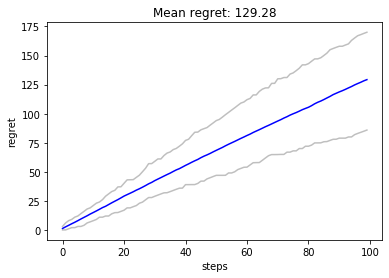

In [20]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()

## 4. Non linear rewards

## 5. Deep Agent